# Import Libraries

In [13]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [14]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                      #  transforms.RandomResizedCrop(28),                                    
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                      #  transforms.RandomAffine( degrees =0,translate=(0.1,0.1), scale=(0.9, 1.1),shear=(-10, 10, 20, 40)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [15]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [16]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# The model
Let's start with the model we first saw

In [17]:
import torch.nn.functional as F
dropout_value = 0.1
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=True),
            nn.ReLU(),
#             nn.BatchNorm2d(8),
#             nn.Dropout(dropout_value)
        ) # output_size = 26 
        #o/p size=16*26*26 RF=3

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=True),
            nn.ReLU(),
#             nn.BatchNorm2d(16),
#             nn.Dropout(dropout_value)
        ) # output_size = 24 
        #o/p size=32*24*24 RF=5

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 24
        #o/p size=10*24*24 RF=5
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12
         #o/p size=10*12*12 RF=6
        

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
#             nn.Dropout(dropout_value)
        ) # output_size = 10
        #o/p size =16*10*10 RF=10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
#             nn.Dropout(dropout_value)
        ) # output_size = 8
        #o/p size = 16*8*8 RF = 14
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        #o/p size = 16*6*6 RF = 18
        
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        
        #o/p size = 16*6*6 RF = 22
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1
        #o/p size = 16*1*1 RF = 32

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        ) 
        #o/p size = 10*1*1 RF = 32


        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)        
        x = self.convblock8(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [18]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              80
              ReLU-2            [-1, 8, 26, 26]               0
            Conv2d-3           [-1, 16, 24, 24]           1,168
              ReLU-4           [-1, 16, 24, 24]               0
            Conv2d-5            [-1, 8, 24, 24]             128
         MaxPool2d-6            [-1, 8, 12, 12]               0
            Conv2d-7           [-1, 16, 10, 10]           1,152
              ReLU-8           [-1, 16, 10, 10]               0
       BatchNorm2d-9           [-1, 16, 10, 10]              32
           Conv2d-10             [-1, 16, 8, 8]           2,304
             ReLU-11             [-1, 16, 8, 8]               0
      BatchNorm2d-12             [-1, 16, 8, 8]              32
           Conv2d-13             [-1, 16, 6, 6]           2,304
             ReLU-14             [

# Training and Testing

All right, so we have 24M params, and that's too many, we know that. But the purpose of this notebook is to set things right for our future experiments. 

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [19]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    reg = 1e-6
    l2_loss = torch.zeros(1)
    l2_loss=l2_loss.to(device)
    for name, param in model.named_parameters():
        if 'bias' not in name:
            l2_loss = l2_loss + ( reg * (torch.norm(param, 2)))
    loss=loss+l2_loss
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [20]:
x=torch.tensor([1.0,2.0,3.0])
print(torch.norm(x,2))

tensor(3.7417)


In [21]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.02, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)


EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    # scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


Loss=0.10451184213161469 Batch_id=468 Accuracy=92.08: 100%|██████████████████████████| 469/469 [00:32<00:00, 15.74it/s]



Test set: Average loss: 0.0791, Accuracy: 9768/10000 (97.68%)

EPOCH: 1


Loss=0.013850672170519829 Batch_id=468 Accuracy=97.91: 100%|█████████████████████████| 469/469 [00:32<00:00, 16.50it/s]



Test set: Average loss: 0.0518, Accuracy: 9846/10000 (98.46%)

EPOCH: 2


Loss=0.06519152969121933 Batch_id=468 Accuracy=98.38: 100%|██████████████████████████| 469/469 [00:31<00:00, 16.40it/s]



Test set: Average loss: 0.0294, Accuracy: 9912/10000 (99.12%)

EPOCH: 3


Loss=0.07635173946619034 Batch_id=468 Accuracy=98.59: 100%|██████████████████████████| 469/469 [00:32<00:00, 15.86it/s]



Test set: Average loss: 0.0258, Accuracy: 9915/10000 (99.15%)

EPOCH: 4


Loss=0.049055155366659164 Batch_id=468 Accuracy=98.89: 100%|█████████████████████████| 469/469 [00:32<00:00, 16.32it/s]



Test set: Average loss: 0.0269, Accuracy: 9914/10000 (99.14%)

EPOCH: 5


Loss=0.03716287389397621 Batch_id=468 Accuracy=98.91: 100%|██████████████████████████| 469/469 [00:31<00:00, 16.25it/s]



Test set: Average loss: 0.0236, Accuracy: 9926/10000 (99.26%)

EPOCH: 6


Loss=0.032406408339738846 Batch_id=468 Accuracy=98.97: 100%|█████████████████████████| 469/469 [00:32<00:00, 15.50it/s]



Test set: Average loss: 0.0238, Accuracy: 9937/10000 (99.37%)

EPOCH: 7


Loss=0.01562991924583912 Batch_id=468 Accuracy=99.00: 100%|██████████████████████████| 469/469 [00:37<00:00, 12.37it/s]



Test set: Average loss: 0.0210, Accuracy: 9938/10000 (99.38%)

EPOCH: 8


Loss=0.013983645476400852 Batch_id=468 Accuracy=99.12: 100%|█████████████████████████| 469/469 [00:47<00:00,  9.92it/s]



Test set: Average loss: 0.0197, Accuracy: 9946/10000 (99.46%)

EPOCH: 9


Loss=0.02736036293208599 Batch_id=468 Accuracy=99.11: 100%|██████████████████████████| 469/469 [00:47<00:00, 14.81it/s]



Test set: Average loss: 0.0189, Accuracy: 9940/10000 (99.40%)

EPOCH: 10


Loss=0.04467225447297096 Batch_id=468 Accuracy=99.16: 100%|██████████████████████████| 469/469 [00:49<00:00,  9.49it/s]



Test set: Average loss: 0.0193, Accuracy: 9944/10000 (99.44%)

EPOCH: 11


Loss=0.009417528286576271 Batch_id=468 Accuracy=99.18: 100%|█████████████████████████| 469/469 [00:48<00:00, 10.52it/s]



Test set: Average loss: 0.0194, Accuracy: 9933/10000 (99.33%)

EPOCH: 12


Loss=0.03394661471247673 Batch_id=468 Accuracy=99.17: 100%|██████████████████████████| 469/469 [00:46<00:00, 10.21it/s]



Test set: Average loss: 0.0192, Accuracy: 9937/10000 (99.37%)

EPOCH: 13


Loss=0.020414017140865326 Batch_id=468 Accuracy=99.26: 100%|█████████████████████████| 469/469 [00:46<00:00,  9.91it/s]



Test set: Average loss: 0.0197, Accuracy: 9937/10000 (99.37%)

EPOCH: 14


Loss=0.04632056877017021 Batch_id=468 Accuracy=99.28: 100%|██████████████████████████| 469/469 [00:46<00:00, 10.09it/s]



Test set: Average loss: 0.0202, Accuracy: 9944/10000 (99.44%)

EPOCH: 15


Loss=0.02708389237523079 Batch_id=468 Accuracy=99.27: 100%|██████████████████████████| 469/469 [00:45<00:00, 10.25it/s]



Test set: Average loss: 0.0197, Accuracy: 9934/10000 (99.34%)

EPOCH: 16


Loss=0.007476335391402245 Batch_id=468 Accuracy=99.31: 100%|█████████████████████████| 469/469 [00:46<00:00, 11.17it/s]



Test set: Average loss: 0.0188, Accuracy: 9933/10000 (99.33%)

EPOCH: 17


Loss=0.09596969187259674 Batch_id=468 Accuracy=99.28: 100%|██████████████████████████| 469/469 [00:48<00:00,  9.67it/s]



Test set: Average loss: 0.0174, Accuracy: 9942/10000 (99.42%)

EPOCH: 18


Loss=0.003358072368428111 Batch_id=468 Accuracy=99.35: 100%|█████████████████████████| 469/469 [00:49<00:00,  9.49it/s]



Test set: Average loss: 0.0194, Accuracy: 9941/10000 (99.41%)

EPOCH: 19


Loss=0.030939118936657906 Batch_id=468 Accuracy=99.40: 100%|█████████████████████████| 469/469 [00:47<00:00,  9.80it/s]



Test set: Average loss: 0.0173, Accuracy: 9942/10000 (99.42%)

EPOCH: 20


Loss=0.013954582624137402 Batch_id=468 Accuracy=99.40: 100%|█████████████████████████| 469/469 [00:45<00:00, 10.30it/s]



Test set: Average loss: 0.0193, Accuracy: 9934/10000 (99.34%)

EPOCH: 21


Loss=0.03137233853340149 Batch_id=468 Accuracy=99.39: 100%|██████████████████████████| 469/469 [00:46<00:00, 10.05it/s]



Test set: Average loss: 0.0183, Accuracy: 9932/10000 (99.32%)

EPOCH: 22


Loss=0.06289738416671753 Batch_id=468 Accuracy=99.41: 100%|██████████████████████████| 469/469 [00:46<00:00, 10.00it/s]



Test set: Average loss: 0.0181, Accuracy: 9938/10000 (99.38%)

EPOCH: 23


Loss=0.008246173150837421 Batch_id=468 Accuracy=99.44: 100%|█████████████████████████| 469/469 [00:46<00:00, 10.07it/s]



Test set: Average loss: 0.0200, Accuracy: 9938/10000 (99.38%)

EPOCH: 24


Loss=0.055236272513866425 Batch_id=468 Accuracy=99.46: 100%|█████████████████████████| 469/469 [00:48<00:00,  9.74it/s]



Test set: Average loss: 0.0173, Accuracy: 9946/10000 (99.46%)

EPOCH: 25


Loss=0.0037116757594048977 Batch_id=468 Accuracy=99.45: 100%|████████████████████████| 469/469 [00:49<00:00, 10.15it/s]



Test set: Average loss: 0.0153, Accuracy: 9943/10000 (99.43%)

EPOCH: 26


Loss=0.0024362443946301937 Batch_id=468 Accuracy=99.45: 100%|████████████████████████| 469/469 [00:49<00:00, 10.30it/s]



Test set: Average loss: 0.0173, Accuracy: 9948/10000 (99.48%)

EPOCH: 27


Loss=0.03051295131444931 Batch_id=468 Accuracy=99.44: 100%|██████████████████████████| 469/469 [00:45<00:00, 10.32it/s]



Test set: Average loss: 0.0178, Accuracy: 9938/10000 (99.38%)

EPOCH: 28


Loss=0.04105406999588013 Batch_id=468 Accuracy=99.43: 100%|██████████████████████████| 469/469 [00:45<00:00, 10.17it/s]



Test set: Average loss: 0.0165, Accuracy: 9945/10000 (99.45%)

EPOCH: 29


Loss=0.0025833328254520893 Batch_id=468 Accuracy=99.50: 100%|████████████████████████| 469/469 [00:45<00:00, 10.21it/s]



Test set: Average loss: 0.0162, Accuracy: 9946/10000 (99.46%)

EPOCH: 30


Loss=0.009625826962292194 Batch_id=468 Accuracy=99.46: 100%|█████████████████████████| 469/469 [00:46<00:00, 10.11it/s]



Test set: Average loss: 0.0177, Accuracy: 9943/10000 (99.43%)

EPOCH: 31


Loss=0.007078129798173904 Batch_id=468 Accuracy=99.52: 100%|█████████████████████████| 469/469 [00:45<00:00, 10.24it/s]



Test set: Average loss: 0.0172, Accuracy: 9943/10000 (99.43%)

EPOCH: 32


Loss=0.024108558893203735 Batch_id=468 Accuracy=99.49: 100%|█████████████████████████| 469/469 [00:47<00:00,  9.86it/s]



Test set: Average loss: 0.0178, Accuracy: 9940/10000 (99.40%)

EPOCH: 33


Loss=0.058026742190122604 Batch_id=468 Accuracy=99.53: 100%|█████████████████████████| 469/469 [00:46<00:00, 10.57it/s]



Test set: Average loss: 0.0156, Accuracy: 9950/10000 (99.50%)

EPOCH: 34


Loss=0.002944821259006858 Batch_id=468 Accuracy=99.49: 100%|█████████████████████████| 469/469 [00:47<00:00,  9.93it/s]



Test set: Average loss: 0.0153, Accuracy: 9952/10000 (99.52%)

EPOCH: 35


Loss=0.00981775764375925 Batch_id=468 Accuracy=99.49: 100%|██████████████████████████| 469/469 [00:42<00:00, 20.70it/s]



Test set: Average loss: 0.0159, Accuracy: 9947/10000 (99.47%)

EPOCH: 36


Loss=0.01384767610579729 Batch_id=468 Accuracy=99.53: 100%|██████████████████████████| 469/469 [00:22<00:00, 20.44it/s]



Test set: Average loss: 0.0172, Accuracy: 9942/10000 (99.42%)

EPOCH: 37


Loss=0.04682456701993942 Batch_id=468 Accuracy=99.50: 100%|██████████████████████████| 469/469 [00:23<00:00, 22.16it/s]



Test set: Average loss: 0.0177, Accuracy: 9944/10000 (99.44%)

EPOCH: 38


Loss=0.009527179412543774 Batch_id=468 Accuracy=99.59: 100%|█████████████████████████| 469/469 [00:26<00:00, 22.18it/s]



Test set: Average loss: 0.0157, Accuracy: 9954/10000 (99.54%)

EPOCH: 39


Loss=0.04294441267848015 Batch_id=468 Accuracy=99.55: 100%|██████████████████████████| 469/469 [00:23<00:00, 21.56it/s]



Test set: Average loss: 0.0159, Accuracy: 9950/10000 (99.50%)



Text(0.5, 1.0, 'Test Accuracy')

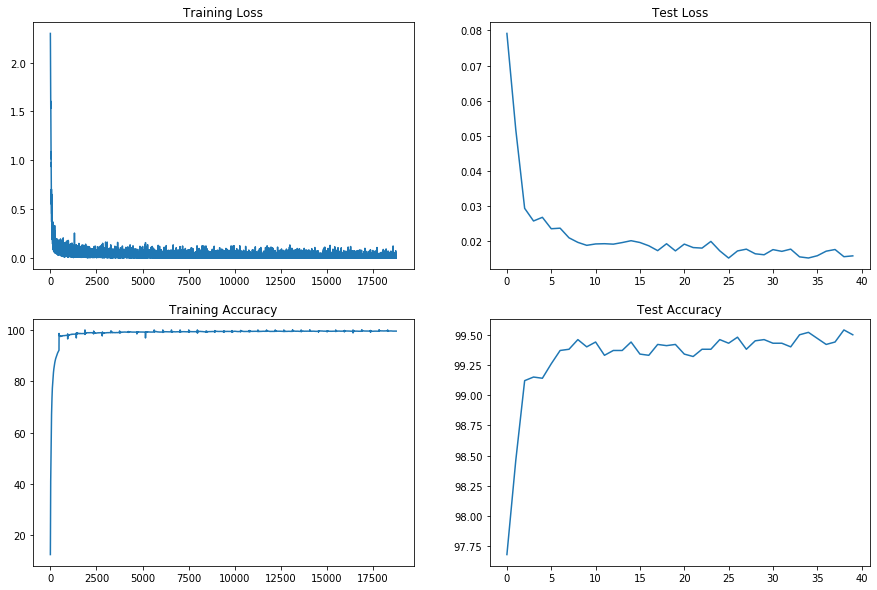

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

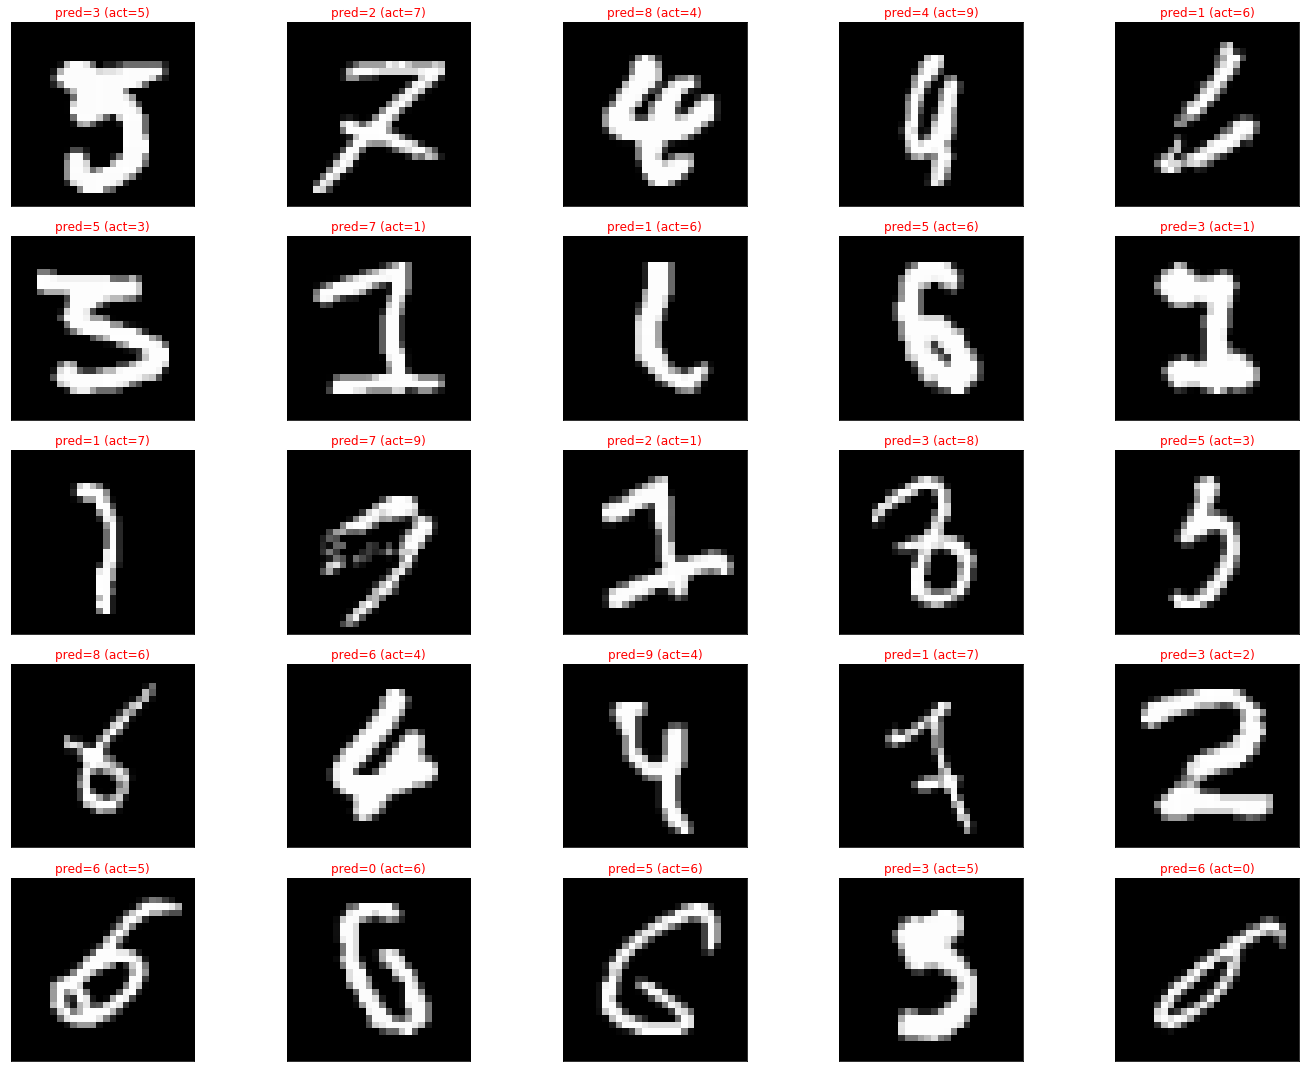

In [31]:
import numpy as np
counter=1
fig = plt.figure(figsize=(20, 15))
for data, target in test_loader:
    data, target = data.to(device), target.to(device)
    output = model(data)
    # convert output probabilities to predicted class
    _, preds = torch.max(output, 1)
    images = data.cpu().numpy()
    #print(np.arange(len(preds.cpu().numpy())))

    if counter < 26:

        for idx in np.arange(len(preds.cpu().numpy())):
            if preds[idx]!=target[idx]:
                ax = fig.add_subplot(5, 5, counter, xticks=[], yticks=[])
                ax.imshow(np.squeeze(images[idx]), cmap='gray')
                ax.set_title("pred={} (act={})".format(str(preds[idx].item()), str(target[idx].item())),
                             color= "red")
            
                counter+=1
        
    else:
        break
        
fig.tight_layout()  
plt.show()